In [1]:
import pandas as pd
import numpy as np
from scipy.special import logit, expit

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, mean_squared_error

import matplotlib.pyplot as plt
from scipy.stats import norm as N

In [2]:
df = pd.read_csv('all_data_logit.csv')

df.loc[(df['state'] == 'DC'), df.columns[df.columns.str.contains('house')]] = 0
df.loc[(df['state'] == 'DC'), 'white_evangelist_pct'] = logit(0.01)

all_df = df
df = df[df['year'] < 2020]

In [3]:
features = [
    'result_house_2', 
    'result_pres_4', 
    'result_pres_8', 
    'result_house_8',
    'result_pres_12',
    'bachelor_higher_pct',
    'asian',
    'unemployment_pct',
    'unemployment_pct_1',
    'white_evangelist_pct',
    'result'
]

to_fold = df[features].dropna(how = 'any')
split = list(KFold(shuffle = True).split(to_fold))

mean_scores = []
w_space = np.linspace(0.5, 0.7, 21)

for s in split:
    scores = []
    fold_train = to_fold.iloc[s[0], :]

    model_election = ElasticNetCV(cv = 5, fit_intercept = False)
    election_features = ['result_house_2', 
                         'result_pres_4', 
                         'result_pres_8', 
                         'result_house_8',
                         'result_pres_12',
                         'result']
    
    df_prev_election = df[df['year'] < 2016][election_features].dropna(how = 'any')
    df_prev_election = pd.concat([df_prev_election, fold_train[election_features]], ignore_index=True)

    X_e = df_prev_election.drop(columns = 'result')
    y_e = df_prev_election['result']
    reg_e = model_election.fit(X_e, y_e)


    model_demographic = ElasticNetCV(cv = 5, fit_intercept = False)
    demographic_features = ['bachelor_higher_pct',
                            'asian',
                            'unemployment_pct',
                            'unemployment_pct_1',
                            'white_evangelist_pct',
                            'result']
    
    df_dem = fold_train[demographic_features]

    X_d = df_dem.drop(columns = 'result')
    y_d = df_dem['result']
    reg_d = model_demographic.fit(X_d, y_d)


    fold_test = to_fold.iloc[s[1], :]
    for w in w_space:
        y_hat_e = reg_e.predict(fold_test[election_features[:-1]])
        y_hat_d = reg_d.predict(fold_test[demographic_features[:-1]])

        y_hat = w * y_hat_e + (1-w) * y_hat_d

        y_train_e = reg_e.predict(fold_train[election_features[:-1]])
        y_train_d = reg_d.predict(fold_train[demographic_features[:-1]])
        y_hat_train = w * y_train_e + (1-w) * y_train_d
        mse = mean_squared_error(fold_train['result'], y_hat_train)


        prob = (1 - N(y_hat, np.sqrt(mse)).cdf(0)).round(5)

        scores.append(log_loss((fold_test['result'] > 0).astype(int).values, prob))
    mean_scores.append(scores)

mean_scores = np.array(mean_scores).mean(axis = 0)

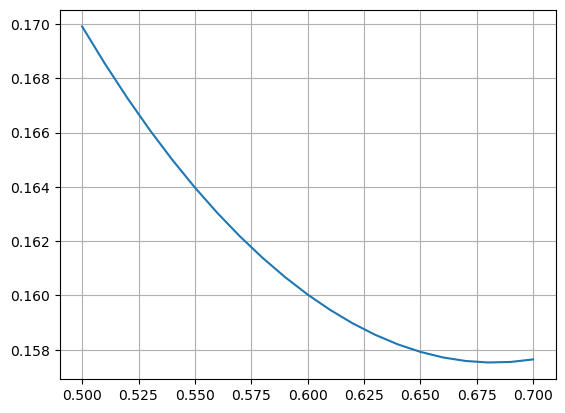

In [4]:
plt.plot(w_space, mean_scores)
plt.grid()
plt.show()

In [5]:
w = 0.66


model_election = ElasticNetCV(cv = 5, fit_intercept = False)
election_features = ['result_house_2', 
                        'result_pres_4', 
                        'result_pres_8', 
                        'result_house_8',
                        'result_pres_12',
                        'result']

df_prev_election = df[election_features].dropna(how = 'any')

X_e = df_prev_election.drop(columns = 'result')
y_e = df_prev_election['result']
reg_e = model_election.fit(X_e, y_e)


model_demographic = ElasticNetCV(cv = 5, fit_intercept = False)
demographic_features = ['bachelor_higher_pct',
                        'asian',
                        'unemployment_pct',
                        'unemployment_pct_1',
                        'white_evangelist_pct',
                        'result']

df_dem = df[demographic_features].dropna(how = 'any')

X_d = df_dem.drop(columns = 'result')
y_d = df_dem['result']
reg_d = model_demographic.fit(X_d, y_d)


df2020 = all_df[all_df['year'] == 2020]
y_hat_e = reg_e.predict(df2020[election_features[:-1]])
y_hat_d = reg_d.predict(df2020[demographic_features[:-1]])

y_hat = w * y_hat_e + (1-w) * y_hat_d

df_train = df[features].dropna(how = 'any')
y_train_e = reg_e.predict(df_train[election_features[:-1]])
y_train_d = reg_d.predict(df_train[demographic_features[:-1]])
y_hat_train = w * y_train_e + (1-w) * y_train_d
mse = mean_squared_error(df_train['result'], y_hat_train)


prob = (1 - N(y_hat, np.sqrt(mse)).cdf(0)).round(5)

In [6]:
df2020_compare = pd.DataFrame()

df2020_compare.loc[:, 'state'] = df2020['state']
df2020_compare.loc[:, 'actual percentage'] = expit(df2020['result'])
df2020_compare.loc[:, 'predicted percentage'] = expit(y_hat)
df2020_compare.loc[:, 'actual result'] = np.where(df2020['result'] > 0, 'R', 'D')
df2020_compare.loc[:, 'predicted result'] = np.where(y_hat > 0, 'R', 'D')
df2020_compare.loc[:, 'differ?'] = np.where(df2020_compare['actual result'] == df2020_compare['predicted result'], '-', 'x')
df2020_compare.loc[:, 'probability'] = prob

In [7]:
df2020_compare

,state,actual percentage,predicted percentage,actual result,predicted result,differ?,probability
561,AK,0.552618,0.521599,R,R,-,0.68304
562,AL,0.629114,0.633733,R,R,-,0.99874
563,AR,0.642124,0.641625,R,R,-,0.99933
564,AZ,0.498432,0.486695,D,D,-,0.38467
565,CA,0.350911,0.344394,D,D,-,0.00020
566,CO,0.430617,0.436406,D,D,-,0.07943
567,CT,0.398050,0.392200,D,D,-,0.00791
568,DC,0.055330,0.055060,D,D,-,0.00000
569,DE,0.403733,0.425001,D,D,-,0.04794
570,FL,0.516948,0.482925,R,D,x,0.35332


In [8]:
np.exp(-log_loss((df2020['result'] > 0).astype(int), prob))

0.8375007415839707

In [9]:
log_loss((df2020['result'] > 0).astype(int), prob)

0.1773331298099097